# This notebook contains the code which prepares training and test datasets for a model trained with the most frequent 5-grams of POS combinations technique, as well as trains and evaluates this model

## Connect the notebook to MyDrive




In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import all necessary libraries

In [2]:
# Standard python libraries for data processing and visualisation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# NLP packages for text processing
from spacy.lang.en import English
import spacy
from collections import Counter
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.util import ngrams

# Libraries to build, train, evaluate, and save an ML model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import pickle

## Initialize nlp instance and download necessary resources


To be able to use English language models for processing textual data we might need to download them first. <br>
To train the model with the most common 5-grams of POS combination feature I used a transformer model with a 438MB size. <br>
To download the transformer model you need to run the following command in the code cell: `!python -m spacy download en_core_web_trf`

In [3]:
nlp = English()
nlp = spacy.load('en_core_web_trf') # tranformer model

## Initialize nlkt instances

In [8]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

## Load train and test datasets


In [4]:
# Import train dataset into pandas DataFrame
train_df = pd.read_csv("drive/MyDrive/python_project/data/train_df.csv")
# Print first 5 rows to see if everything is imported correctly and data is shuffled as we did it at the end of the data-preprocessing notebook
print(train_df.head())

# Import test dataset into pandas DataFrame
test_df = pd.read_csv("drive/MyDrive/python_project/data/test_df.csv")
# Print first 5 rows to see if everything is imported correctly and data is shuffled as we did it at the end of the data-preprocessing notebook
print(test_df.head())

                                            dialogue     name
0   I’ll say it looks good. It’s in my proprietar...  Sheldon
1   Wait, wait, wait. When did you send my mom no...  Leonard
2            I never had a beer with my dad, either.   Howard
3                      My thank you was not sincere.  Sheldon
4   I’m calling to invite you to a spontaneous da...  Sheldon
                                            dialogue     name
0                      Yeah, that’s when it started.  Leonard
1   A million dollars? God, it’s like my nuts jus...   Howard
2   Dinner’s almost ready. If you like meatloaf, ...   Howard
3   Well, Leonard, I think it’s high time you and...  Sheldon
4              All right. It is a comfortable chair.  Sheldon


## Feature engineering

## Get 5-grams of POS combinations per character

In [9]:
# Create a dictionary to store 5-grams of POS combinations frequencies per name
pos_grams_freq_per_name = {}

# Iterate over each name in the DataFrame
for name in train_df['name'].unique():
    # Get the dialogues for the current name
    dialogues = train_df.loc[train_df['name'] == name, 'dialogue']

    # Tokenize, lemmatize, and extract adjective + noun bigrams
    all_pos_grams = []
    for dialogue in dialogues:
        tokens = nltk.word_tokenize(str(dialogue))
        tokens = [token for token in tokens if token not in string.punctuation]
        pos_tokens_tags = nltk.pos_tag(tokens)
        pos_tags = []
        for pos in pos_tokens_tags:
            pos_tags.append(pos[1])
        pos_grams = ngrams(pos_tags, 5)
        pos_grams_list = [" ".join(map(str, gram)) for gram in pos_grams]
        all_pos_grams.extend(pos_grams_list)

    # Calculate the bigram frequencies
    pos_grams_freq = Counter(all_pos_grams)

    # Store the bigram frequencies for the current name
    pos_grams_freq_per_name[name] = pos_grams_freq.most_common(10)  # Change the number to get more or fewer common bigrams

# Print the top 10 'adjective' + 'noun' bigrams per name
for name, freq_pos_bigrams in pos_grams_freq_per_name.items():
    print(f"Top 10 5-grams of POS combinations for {name}:")
    for pos_gram, freq in freq_pos_bigrams:
        print(f"- {pos_gram}: {freq}")
    print()

Top 10 5-grams of POS combinations for Sheldon:
- NNP NNP NNP NNP NNP: 162
- NN IN DT JJ NN: 114
- PRP VBP JJ NN VBP: 104
- DT NN IN DT NN: 102
- JJ NN IN DT NN: 87
- DT JJ NN IN DT: 72
- PRP VBP JJ NN NN: 71
- NN PRP VBP JJ NN: 71
- NN IN DT NN IN: 70
- PRP VBP JJ NN PRP: 65

Top 10 5-grams of POS combinations for Leonard:
- PRP VBP JJ NN VBP: 128
- DT NN IN DT NN: 64
- NN PRP VBP JJ NN: 62
- PRP VBP JJ NNS VBP: 54
- PRP VBP JJ NN TO: 53
- NNP PRP VBP JJ NN: 52
- IN PRP VBP JJ NN: 51
- PRP VBP JJ NN IN: 51
- PRP VBP JJ NN PRP: 50
- PRP VBP RB VBG TO: 48

Top 10 5-grams of POS combinations for Howard:
- PRP VBP JJ NN VBP: 117
- DT NN IN DT NN: 70
- PRP VBP JJ NNS VBP: 70
- PRP VBP JJ NN PRP: 62
- NN PRP VBP JJ NN: 56
- PRP VBP JJ NN TO: 55
- NN IN DT JJ NN: 53
- IN PRP VBP JJ NN: 51
- PRP VBP JJ NN NN: 50
- VBP JJ NN TO VB: 47

Top 10 5-grams of POS combinations for Penny:
- PRP VBP JJ NN VBP: 119
- NN PRP VBP JJ NN: 73
- PRP VBP JJ NN TO: 67
- NNP PRP VBP JJ NN: 58
- VBP JJ NN TO VB: 

## Get unique 5-grams of POS combinations

In [10]:
# Get all the values of the pos_grams_freq_per_name dictionary which are tuple of 5-grams of POS combinations and their frequencies
pos_grams_freq_list = pos_grams_freq_per_name.values()
# pos_grams_freq_per_name is the list of lists of 5-grams of POS combinations + frequency tuples
# To get only 5-grams of POS combinations without frequencies we need to iterate through the list of lists of 5-grams of POS combinations + frequency tuples and then through lists of 5-grams of POS combinations + frequency tuples and get the first element of the tuple
# For this we used a list comprehension
unique_freq_pos_grams = [pos_gram_freq[0] for pos_grams_freqs in pos_grams_freq_list for pos_gram_freq in pos_grams_freqs]
# To get only unique 5-grams of POS combinations we cast the list of 5-grams of POS combinations into a set and then cast it back to a list
unique_freq_pos_grams = list(set(unique_freq_pos_grams))
# Print the list and length of unique 5-grams of POS combinations
print(unique_freq_pos_grams)
print(len(unique_freq_pos_grams))

['DT JJ NN IN DT', 'NN PRP VBP JJ NN', 'NNP NNP NNP NNP NNP', 'NN IN DT JJ NN', 'PRP VBP JJ NN TO', 'PRP VBP JJ NNS VBP', 'NNP PRP VBP JJ NN', 'PRP VBP JJ NN IN', 'VBP JJ NN TO VB', 'PRP VBP RB VBG TO', 'JJ NN IN DT NN', 'NN IN DT NN IN', 'RB PRP VBP JJ NN', 'PRP VBP JJ NN PRP', 'PRP VBP JJ NN NN', 'DT NN IN DT NN', 'IN PRP VBP JJ NN', 'PRP VBP JJ NN VBP']
18


## Prepare train and test datasets for the model to be trained with 5-grams of POS combination technique

In [11]:
# Get a list of dialogues and names from the train dataset
train_dialogues = train_df['dialogue'].astype(str).apply(lambda x: x.lower()).to_list()
train_names = train_df['name'].astype(str).apply(lambda x: x.lower()).to_list()
print(train_dialogues[:5])
print(train_names[:5])

# Get a list of dialogues and names from the test dataset
test_dialogues = test_df['dialogue'].astype(str).apply(lambda x: x.lower()).to_list()
test_names = test_df['name'].astype(str).apply(lambda x: x.lower()).to_list()
print(test_dialogues[:5])
print(test_names[:5])

[' i’ll say it looks good. it’s in my proprietary font, shelvetica.', ' wait, wait, wait. when did you send my mom notes on a paper?', ' i never had a beer with my dad, either.', ' my thank you was not sincere.', ' i’m calling to invite you to a spontaneous date night tomorrow evening.']
['sheldon', 'leonard', 'howard', 'sheldon', 'sheldon']
[' yeah, that’s when it started.', ' a million dollars? god, it’s like my nuts just kicked me in the nuts. that’s it, i got to start earning more money right now.', ' dinner’s almost ready. if you like meatloaf, i’m sure you’ll like its cousin, bowl of meat.', ' well, leonard, i think it’s high time you and i address the tweepadock in the room.', ' all right. it is a comfortable chair.']
['leonard', 'howard', 'howard', 'sheldon', 'sheldon']


In [12]:
# Get train numpy array with values as zeros in the shape of train_dialogues length * unique_freq_nouns length
train_features = np.zeros((len(train_dialogues), len(unique_freq_pos_grams)))

# Print the shape of this 2d array
print(train_features.shape)

# Get test numpy array with values as zeros in the shape of train_dialogues length * unique_freq_nouns length
test_features = np.zeros((len(test_dialogues), len(unique_freq_pos_grams)))

# Print the shape of this 2d array
print(test_features.shape)

(18468, 18)
(4596, 18)


Fill in the train_features and test_features with 1 if the 5-grams of POS combination is in the dialogue

In [13]:
# Initialize a train_doc_dialogues generator
train_doc_dialogues = nlp.pipe(train_dialogues)

# Iterate throguh train_doc_dialogues generator and train_features numpy array
for dialogue, f in zip(train_doc_dialogues, train_features):
    # tag POS to each token
    tokens = nltk.word_tokenize(str(dialogue))
    tokens = [token for token in tokens if token not in string.punctuation]
    pos_tokens_tags = nltk.pos_tag(tokens)
    # create a 5-grams of POS combination list from all words in the dialogue
    pos_tags = []
    for pos in pos_tokens_tags:
        pos_tags.append(pos[1])
    pos_grams = ngrams(pos_tags, 5)
    pos_grams_list = [" ".join(map(str, gram)) for gram in pos_grams]
    # iterate through the unique list of 5-grams of POS combinations
    for pos_gram in unique_freq_pos_grams:
        # if the 5-gram of POS combination is in the dialogue
        if pos_gram in pos_grams_list:
            # get the index number of it
            pos_gram_id = unique_freq_pos_grams.index(pos_gram)
            # replace the value of the feature array at the given index with 1
            f[pos_gram_id] = 1

In [14]:
# Initialize a test_doc_dialogues generator
test_doc_dialogues = nlp.pipe(test_dialogues)

# Iterate throguh test_doc_dialogues generator and test_features numpy array
for dialogue, f in zip(test_doc_dialogues, test_features):
    # tag POS to each token
    tokens = nltk.word_tokenize(str(dialogue))
    tokens = [token for token in tokens if token not in string.punctuation]
    pos_tokens_tags = nltk.pos_tag(tokens)
    # create a 5-grams of POS combination list from all words in the dialogue
    pos_tags = []
    for pos in pos_tokens_tags:
        pos_tags.append(pos[1])
    pos_grams = ngrams(pos_tags, 5)
    pos_grams_list = [" ".join(map(str, gram)) for gram in pos_grams]
    # iterate through the unique list of 5-grams of POS combinations
    for pos_gram in pos_grams_list:
        # if the 5-gram of POS combination is in the dialogue
        if pos_gram in unique_freq_pos_grams:
            # get the index number of it
            pos_gram_id = unique_freq_pos_grams.index(pos_gram)
            # replace the value of the feature array at the given index with 1
            f[pos_gram_id] = 1

## Train model with 5-grams POS combinations

In [15]:
# Make an instance of the Model from LogisticRegression class
lr_pos = LogisticRegression()

# Train the model
lr_pos.fit(train_features, train_names)

# Print the labels
print(lr_pos.classes_)

# Print parameters of the model
print(lr_pos.get_params())

['howard' 'leonard' 'penny' 'sheldon']
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


## Save the logistic regression model to be trained with 5-grams of POS combinations technique

In [16]:
with open("drive/MyDrive/python_project/lr_pos_model.pkl", 'wb') as file:
    pickle.dump(lr_pos, file)

## Get predictions

In [17]:
# Define a funtion that will take the index of the dialogue in the test features and predict the name to whom this dialogue might belong
def getPrediction(model):
    predictions = model.predict(test_features)
    return predictions

## Evaluate the logistic regression model trained with 5-grams POS combinations feature

### Accuracy

In [18]:
# Get prediction of all dialogues
predictions_lr = getPrediction(lr_pos)
# Use accuracy_score funtion to calculate the accuracy
accuracy = accuracy_score(test_names, predictions_lr)
# Print the accuracy
print("Accuracy of the model trained with 5-grams of POS combinations feature:", accuracy)

Accuracy of the model trained with 5-grams of POS combinations feature: 0.26718885987815494


### Confusion matrix visualization

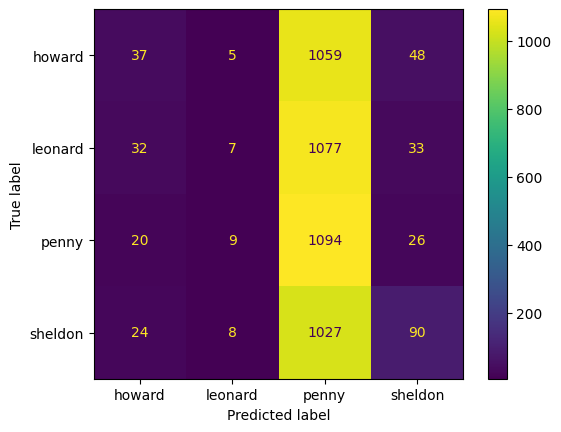

In [19]:
# Get the labels
labels = lr_pos.classes_
# Get the confusion matrix
cm = confusion_matrix(test_names, predictions_lr, labels=labels)
# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()

### Get classification report

In [20]:
# Print the classification report
print(classification_report(test_names, predictions_lr))

              precision    recall  f1-score   support

      howard       0.33      0.03      0.06      1149
     leonard       0.24      0.01      0.01      1149
       penny       0.26      0.95      0.40      1149
     sheldon       0.46      0.08      0.13      1149

    accuracy                           0.27      4596
   macro avg       0.32      0.27      0.15      4596
weighted avg       0.32      0.27      0.15      4596

